In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
# !pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

In [3]:
DEBUG = False

In [4]:
# pip install timm

In [5]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [6]:
import os
import sys
sys.path = [
    '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
] + sys.path

In [7]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import timm
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm

# Config

In [8]:
data_dir = '/media/frank/ext_drive/data/kaggle_panda/'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'efficientnet_esfrankpuk'

#enet_type = 'efficientnet-b0'
fold = 1
tile_size = 256
image_size = 256
n_tiles = 24
batch_size = 8
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 3 if DEBUG else 100
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

/media/frank/ext_drive/data/kaggle_panda/train_images


# Create Folds

In [9]:
skf = StratifiedKFold(2, shuffle=True, random_state = 42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,1
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,1


# Model

In [10]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = backbone
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [11]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [12]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

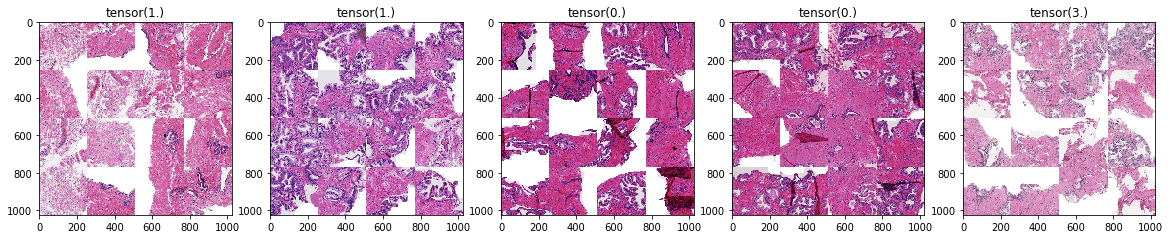

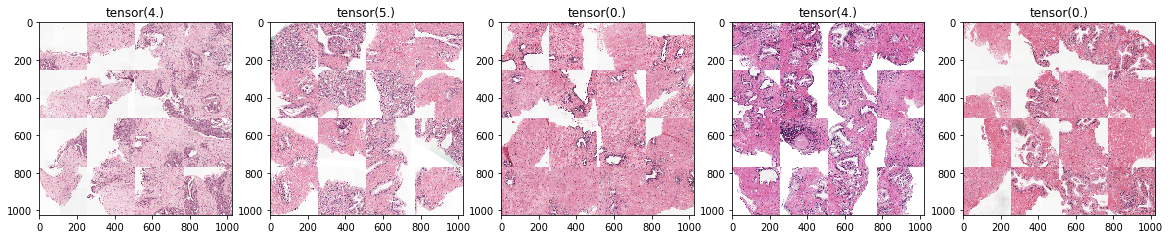

In [13]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [14]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [15]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [16]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)


model = timm.create_model('efficientnet_es', pretrained=True)

enet_type = model
model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

5308 5308


In [17]:
model.avg_pool = GeM()


# Run Training

In [ ]:
%%time

qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'

scaler = GradScaler()

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    if(epoch>1):
        scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk
        
    torch.save(model.state_dict(), os.path.join(f'{kernel_type}_fold{fold}_epoch_{epoch}.pth'))

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Fri Jul 10 15:25:53 2020 Epoch: 1


/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



qwk 0.7002899619436529 qwk_k 0.6627616164440413 qwk_r 0.6545083060259281
Fri Jul 10 15:41:00 2020 Epoch 1, lr: 0.0000300, train loss: 0.44932, val loss: 0.33848, acc: 37.32102, qwk: 0.70029
score2 (0.000000 --> 0.700290).  Saving model ...
Fri Jul 10 15:41:00 2020 Epoch: 2


/home/frank/miniconda3/envs/py37/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



qwk 0.7629924557568601 qwk_k 0.7461106020745789 qwk_r 0.708833496812226
Fri Jul 10 15:54:40 2020 Epoch 2, lr: 0.0003000, train loss: 0.37230, val loss: 0.31038, acc: 39.50641, qwk: 0.76299
score2 (0.700290 --> 0.762992).  Saving model ...
Fri Jul 10 15:54:40 2020 Epoch: 3



qwk 0.8133204527669328 qwk_k 0.799257467493212 qwk_r 0.7718086339598171
Fri Jul 10 16:08:10 2020 Epoch 3, lr: 0.0000300, train loss: 0.30646, val loss: 0.26556, acc: 51.41296, qwk: 0.81332
score2 (0.762992 --> 0.813320).  Saving model ...
Fri Jul 10 16:08:10 2020 Epoch: 4



qwk 0.7901836505779477 qwk_k 0.7625515285389699 qwk_r 0.7503693252708086
Fri Jul 10 16:21:38 2020 Epoch 4, lr: 0.0002997, train loss: 0.32911, val loss: 0.30178, acc: 52.54333, qwk: 0.79018
Fri Jul 10 16:21:38 2020 Epoch: 5



qwk 0.7814744412926761 qwk_k 0.7662176185958818 qwk_r 0.7449969063024254
Fri Jul 10 16:35:14 2020 Epoch 5, lr: 0.0002993, train loss: 0.30318, val loss: 0.29267, acc: 41.03240, qwk: 0.78147
Fri Jul 10 16:35:14 2020 Epoch: 6



qwk 0.7969933835873546 qwk_k 0.8081913353320527 qwk_r 0.7368290740081619
Fri Jul 10 16:48:40 2020 Epoch 6, lr: 0.0002988, train loss: 0.28421, val loss: 0.32114, acc: 46.47702, qwk: 0.79699
Fri Jul 10 16:48:40 2020 Epoch: 7



qwk 0.8233733831457735 qwk_k 0.8182531622485611 qwk_r 0.7837253253780762
Fri Jul 10 17:02:05 2020 Epoch 7, lr: 0.0002981, train loss: 0.26874, val loss: 0.26168, acc: 55.35041, qwk: 0.82337
score2 (0.813320 --> 0.823373).  Saving model ...
Fri Jul 10 17:02:05 2020 Epoch: 8



qwk 0.8327420784967696 qwk_k 0.8356115495526062 qwk_r 0.7869550980262803
Fri Jul 10 17:15:32 2020 Epoch 8, lr: 0.0002973, train loss: 0.26253, val loss: 0.25697, acc: 53.54182, qwk: 0.83274
score2 (0.823373 --> 0.832742).  Saving model ...
Fri Jul 10 17:15:32 2020 Epoch: 9



qwk 0.8154796430507039 qwk_k 0.8171294246587477 qwk_r 0.777252890716525
Fri Jul 10 17:28:58 2020 Epoch 9, lr: 0.0002963, train loss: 0.24875, val loss: 0.26156, acc: 49.75509, qwk: 0.81548
Fri Jul 10 17:28:58 2020 Epoch: 10



qwk 0.8404146630817318 qwk_k 0.8437175906793475 qwk_r 0.7995580471495473
Fri Jul 10 17:42:23 2020 Epoch 10, lr: 0.0002952, train loss: 0.24497, val loss: 0.24675, acc: 57.27204, qwk: 0.84041
score2 (0.832742 --> 0.840415).  Saving model ...
Fri Jul 10 17:42:23 2020 Epoch: 11



qwk 0.8236144868975601 qwk_k 0.835581527196325 qwk_r 0.7766252384495148
Fri Jul 10 17:55:49 2020 Epoch 11, lr: 0.0002939, train loss: 0.23764, val loss: 0.24670, acc: 57.46044, qwk: 0.82361
Fri Jul 10 17:55:49 2020 Epoch: 12



qwk 0.8170797989289074 qwk_k 0.8410644640289585 qwk_r 0.7546313981341137
Fri Jul 10 18:09:20 2020 Epoch 12, lr: 0.0002925, train loss: 0.22811, val loss: 0.25618, acc: 56.80106, qwk: 0.81708
Fri Jul 10 18:09:20 2020 Epoch: 13



qwk 0.8363701402127439 qwk_k 0.8410331739779825 qwk_r 0.7964485674398311
Fri Jul 10 18:22:54 2020 Epoch 13, lr: 0.0002910, train loss: 0.22271, val loss: 0.25228, acc: 58.42125, qwk: 0.83637
Fri Jul 10 18:22:54 2020 Epoch: 14



qwk 0.8445240081868873 qwk_k 0.8539715330858494 qwk_r 0.79956870266114
Fri Jul 10 18:36:20 2020 Epoch 14, lr: 0.0002893, train loss: 0.21622, val loss: 0.24249, acc: 57.55463, qwk: 0.84452
score2 (0.840415 --> 0.844524).  Saving model ...
Fri Jul 10 18:36:20 2020 Epoch: 15



qwk 0.8260141875624222 qwk_k 0.8467191148078305 qwk_r 0.7726276005175435
Fri Jul 10 18:49:46 2020 Epoch 15, lr: 0.0002874, train loss: 0.20634, val loss: 0.25551, acc: 55.89676, qwk: 0.82601
Fri Jul 10 18:49:46 2020 Epoch: 16



qwk 0.8244183313484293 qwk_k 0.8236452511881223 qwk_r 0.7856559697966947
Fri Jul 10 19:03:13 2020 Epoch 16, lr: 0.0002854, train loss: 0.20419, val loss: 0.27545, acc: 56.70686, qwk: 0.82442
Fri Jul 10 19:03:13 2020 Epoch: 17



qwk 0.8444566655694787 qwk_k 0.8501927433056254 qwk_r 0.8043482521649569
Fri Jul 10 19:16:37 2020 Epoch 17, lr: 0.0002833, train loss: 0.19941, val loss: 0.25362, acc: 58.60965, qwk: 0.84446
Fri Jul 10 19:16:37 2020 Epoch: 18



qwk 0.8325212210082464 qwk_k 0.8467114583183334 qwk_r 0.7813221299674087
Fri Jul 10 19:30:03 2020 Epoch 18, lr: 0.0002811, train loss: 0.19064, val loss: 0.27356, acc: 59.90957, qwk: 0.83252
Fri Jul 10 19:30:03 2020 Epoch: 19



qwk 0.8519113638583816 qwk_k 0.8581316151352449 qwk_r 0.8158496000901024
Fri Jul 10 19:44:07 2020 Epoch 19, lr: 0.0002787, train loss: 0.18613, val loss: 0.27530, acc: 60.62547, qwk: 0.85191
score2 (0.844524 --> 0.851911).  Saving model ...
Fri Jul 10 19:44:07 2020 Epoch: 20



qwk 0.8378673340596571 qwk_k 0.843256010526687 qwk_r 0.8008824616484989
Fri Jul 10 19:57:35 2020 Epoch 20, lr: 0.0002762, train loss: 0.18221, val loss: 0.26003, acc: 62.86737, qwk: 0.83787
Fri Jul 10 19:57:35 2020 Epoch: 21



qwk 0.8288729317265532 qwk_k 0.8275940388415903 qwk_r 0.7887586139101787
Fri Jul 10 20:10:54 2020 Epoch 21, lr: 0.0002736, train loss: 0.16952, val loss: 0.29240, acc: 56.04748, qwk: 0.82887
Fri Jul 10 20:10:54 2020 Epoch: 22



qwk 0.8486838006627597 qwk_k 0.8461000800368679 qwk_r 0.8129335878365036
Fri Jul 10 20:24:26 2020 Epoch 22, lr: 0.0002708, train loss: 0.17292, val loss: 0.26077, acc: 60.53127, qwk: 0.84868
Fri Jul 10 20:24:26 2020 Epoch: 23



qwk 0.8460392285390143 qwk_k 0.8421834852377952 qwk_r 0.8163619248049239
Fri Jul 10 20:38:06 2020 Epoch 23, lr: 0.0002679, train loss: 0.16319, val loss: 0.25779, acc: 60.98342, qwk: 0.84604
Fri Jul 10 20:38:06 2020 Epoch: 24



qwk 0.8421307094544928 qwk_k 0.8504078019253372 qwk_r 0.8037675287974636
Fri Jul 10 20:51:55 2020 Epoch 24, lr: 0.0002649, train loss: 0.16087, val loss: 0.26627, acc: 61.73700, qwk: 0.84213
Fri Jul 10 20:51:55 2020 Epoch: 25



qwk 0.834040853633811 qwk_k 0.8275916791697657 qwk_r 0.8035229819816253
Fri Jul 10 21:05:26 2020 Epoch 25, lr: 0.0002618, train loss: 0.15427, val loss: 0.28283, acc: 62.64130, qwk: 0.83404
Fri Jul 10 21:05:26 2020 Epoch: 26



qwk 0.8267363417210734 qwk_k 0.8318640284034162 qwk_r 0.7837089279459363
Fri Jul 10 21:18:57 2020 Epoch 26, lr: 0.0002586, train loss: 0.15195, val loss: 0.31466, acc: 55.23738, qwk: 0.82674
Fri Jul 10 21:18:57 2020 Epoch: 27



qwk 0.8522867516006924 qwk_k 0.8520858525608004 qwk_r 0.8230520493738239
Fri Jul 10 21:32:24 2020 Epoch 27, lr: 0.0002552, train loss: 0.14113, val loss: 0.27267, acc: 62.54710, qwk: 0.85229
score2 (0.851911 --> 0.852287).  Saving model ...
Fri Jul 10 21:32:24 2020 Epoch: 28



qwk 0.8476490614213805 qwk_k 0.8552554718014632 qwk_r 0.8082711097935065
Fri Jul 10 21:46:06 2020 Epoch 28, lr: 0.0002518, train loss: 0.14074, val loss: 0.25853, acc: 60.51243, qwk: 0.84765
Fri Jul 10 21:46:06 2020 Epoch: 29



qwk 0.8453443170416182 qwk_k 0.8567581962050502 qwk_r 0.8087716790054352
Fri Jul 10 21:59:31 2020 Epoch 29, lr: 0.0002482, train loss: 0.13610, val loss: 0.29348, acc: 62.32102, qwk: 0.84534
Fri Jul 10 21:59:31 2020 Epoch: 30



qwk 0.8390690952988646 qwk_k 0.8411196538617227 qwk_r 0.8065480855466675
Fri Jul 10 22:13:05 2020 Epoch 30, lr: 0.0002446, train loss: 0.12833, val loss: 0.29444, acc: 62.26451, qwk: 0.83907
Fri Jul 10 22:13:05 2020 Epoch: 31



qwk 0.835752615778577 qwk_k 0.838653372393064 qwk_r 0.7970691471851283
Fri Jul 10 22:26:39 2020 Epoch 31, lr: 0.0002408, train loss: 0.12931, val loss: 0.31014, acc: 55.82140, qwk: 0.83575
Fri Jul 10 22:26:39 2020 Epoch: 32



qwk 0.8549126837201615 qwk_k 0.860156939934369 qwk_r 0.8208760278834449
Fri Jul 10 22:40:10 2020 Epoch 32, lr: 0.0002370, train loss: 0.12572, val loss: 0.28908, acc: 62.24567, qwk: 0.85491
score2 (0.852287 --> 0.854913).  Saving model ...
Fri Jul 10 22:40:10 2020 Epoch: 33



qwk 0.826206427814028 qwk_k 0.8245570676610365 qwk_r 0.7920615781453515
Fri Jul 10 22:53:38 2020 Epoch 33, lr: 0.0002331, train loss: 0.12069, val loss: 0.33863, acc: 63.99774, qwk: 0.82621
Fri Jul 10 22:53:38 2020 Epoch: 34



qwk 0.841614269903716 qwk_k 0.8409729432182715 qwk_r 0.8023618669973813
Fri Jul 10 23:07:04 2020 Epoch 34, lr: 0.0002291, train loss: 0.11301, val loss: 0.32097, acc: 60.87038, qwk: 0.84161
Fri Jul 10 23:07:04 2020 Epoch: 35



qwk 0.8446053409235426 qwk_k 0.8544165413277143 qwk_r 0.8043719129757876
Fri Jul 10 23:20:29 2020 Epoch 35, lr: 0.0002250, train loss: 0.10863, val loss: 0.32697, acc: 60.24868, qwk: 0.84461
Fri Jul 10 23:20:29 2020 Epoch: 36



qwk 0.8376361521278962 qwk_k 0.8453801350784016 qwk_r 0.7957083579841212
Fri Jul 10 23:34:07 2020 Epoch 36, lr: 0.0002208, train loss: 0.10983, val loss: 0.30406, acc: 60.55011, qwk: 0.83764
Fri Jul 10 23:34:07 2020 Epoch: 37



qwk 0.8444282145159987 qwk_k 0.8477059757707749 qwk_r 0.8116327357963504
Fri Jul 10 23:47:39 2020 Epoch 37, lr: 0.0002166, train loss: 0.10269, val loss: 0.34641, acc: 62.17031, qwk: 0.84443
Fri Jul 10 23:47:40 2020 Epoch: 38



qwk 0.8466117906607703 qwk_k 0.8464221902287379 qwk_r 0.8146874018484909
Sat Jul 11 00:01:13 2020 Epoch 38, lr: 0.0002123, train loss: 0.09492, val loss: 0.35280, acc: 63.77167, qwk: 0.84661
Sat Jul 11 00:01:13 2020 Epoch: 39



qwk 0.8381199434561502 qwk_k 0.839058216660973 qwk_r 0.8045561695728762
Sat Jul 11 00:14:40 2020 Epoch 39, lr: 0.0002080, train loss: 0.09538, val loss: 0.35178, acc: 64.31801, qwk: 0.83812
Sat Jul 11 00:14:40 2020 Epoch: 40



qwk 0.8501233967388719 qwk_k 0.8557439728937688 qwk_r 0.816369718625113
Sat Jul 11 00:28:06 2020 Epoch 40, lr: 0.0002035, train loss: 0.09171, val loss: 0.32229, acc: 64.01658, qwk: 0.85012
Sat Jul 11 00:28:06 2020 Epoch: 41



qwk 0.8387714273764832 qwk_k 0.845083214952704 qwk_r 0.802010061422883
Sat Jul 11 00:41:31 2020 Epoch 41, lr: 0.0001991, train loss: 0.08903, val loss: 0.31104, acc: 62.79201, qwk: 0.83877
Sat Jul 11 00:41:31 2020 Epoch: 42



qwk 0.8511211427603638 qwk_k 0.858206643707798 qwk_r 0.8158025790356883
Sat Jul 11 00:55:00 2020 Epoch 42, lr: 0.0001945, train loss: 0.08338, val loss: 0.33848, acc: 63.79050, qwk: 0.85112
Sat Jul 11 00:55:00 2020 Epoch: 43



qwk 0.8453805280299518 qwk_k 0.8489690138541304 qwk_r 0.8094173449842279
Sat Jul 11 01:09:23 2020 Epoch 43, lr: 0.0001900, train loss: 0.08243, val loss: 0.33424, acc: 62.77317, qwk: 0.84538
Sat Jul 11 01:09:23 2020 Epoch: 44



qwk 0.8424749898319481 qwk_k 0.845940107965728 qwk_r 0.8079744332358537
Sat Jul 11 01:23:41 2020 Epoch 44, lr: 0.0001854, train loss: 0.08141, val loss: 0.35227, acc: 62.54710, qwk: 0.84247
Sat Jul 11 01:23:41 2020 Epoch: 45



qwk 0.8498658776281685 qwk_k 0.8472247762932942 qwk_r 0.8195140903335421
Sat Jul 11 01:37:53 2020 Epoch 45, lr: 0.0001807, train loss: 0.07537, val loss: 0.35100, acc: 63.43255, qwk: 0.84987
Sat Jul 11 01:37:53 2020 Epoch: 46



qwk 0.8483479247257567 qwk_k 0.8469213328294087 qwk_r 0.8201945466019629
Sat Jul 11 01:51:46 2020 Epoch 46, lr: 0.0001760, train loss: 0.07252, val loss: 0.34823, acc: 62.69781, qwk: 0.84835
Sat Jul 11 01:51:47 2020 Epoch: 47



qwk 0.839513617526637 qwk_k 0.8399785987477885 qwk_r 0.8061673409161444
Sat Jul 11 02:05:58 2020 Epoch 47, lr: 0.0001713, train loss: 0.06896, val loss: 0.40472, acc: 65.46722, qwk: 0.83951
Sat Jul 11 02:05:58 2020 Epoch: 48



qwk 0.8401639553139992 qwk_k 0.849409008241929 qwk_r 0.8021928885815378
Sat Jul 11 02:19:47 2020 Epoch 48, lr: 0.0001666, train loss: 0.06297, val loss: 0.35179, acc: 63.16880, qwk: 0.84016
Sat Jul 11 02:19:47 2020 Epoch: 49



qwk 0.8341932561937272 qwk_k 0.84250696762264 qwk_r 0.7957956568005267
Sat Jul 11 02:33:11 2020 Epoch 49, lr: 0.0001619, train loss: 0.06586, val loss: 0.37450, acc: 63.96006, qwk: 0.83419
Sat Jul 11 02:33:11 2020 Epoch: 50



qwk 0.8485283424059615 qwk_k 0.8406750357286514 qwk_r 0.8245024867251277
Sat Jul 11 02:46:38 2020 Epoch 50, lr: 0.0001571, train loss: 0.06271, val loss: 0.36490, acc: 63.31952, qwk: 0.84853
Sat Jul 11 02:46:38 2020 Epoch: 51



qwk 0.8384873125967349 qwk_k 0.8301435302017848 qwk_r 0.8101126662670151
Sat Jul 11 03:13:40 2020 Epoch 51, lr: 0.0001524, train loss: 0.05882, val loss: 0.36026, acc: 62.88621, qwk: 0.83849
Sat Jul 11 03:13:40 2020 Epoch: 52



qwk 0.8419801051688308 qwk_k 0.832515109478431 qwk_r 0.8143422238572543
Sat Jul 11 03:33:49 2020 Epoch 52, lr: 0.0001476, train loss: 0.05597, val loss: 0.36731, acc: 64.01658, qwk: 0.84198
Sat Jul 11 03:33:49 2020 Epoch: 53



qwk 0.8384439878343656 qwk_k 0.8357210624538212 qwk_r 0.8068380648538171
Sat Jul 11 04:04:44 2020 Epoch 53, lr: 0.0001429, train loss: 0.05554, val loss: 0.38528, acc: 64.28033, qwk: 0.83844
Sat Jul 11 04:04:44 2020 Epoch: 54



qwk 0.8435217162059054 qwk_k 0.842064599704901 qwk_r 0.8140704863074273
Sat Jul 11 04:18:03 2020 Epoch 54, lr: 0.0001381, train loss: 0.05140, val loss: 0.39123, acc: 62.94273, qwk: 0.84352
Sat Jul 11 04:18:03 2020 Epoch: 55



qwk 0.8468261957184711 qwk_k 0.8450334836151858 qwk_r 0.8143433239276398
Sat Jul 11 05:22:14 2020 Epoch 55, lr: 0.0001334, train loss: 0.04799, val loss: 0.37092, acc: 62.99925, qwk: 0.84683
Sat Jul 11 05:22:14 2020 Epoch: 56



qwk 0.8509669342242021 qwk_k 0.850911498847271 qwk_r 0.819678240884527
Sat Jul 11 05:44:23 2020 Epoch 56, lr: 0.0001287, train loss: 0.04556, val loss: 0.39800, acc: 65.42954, qwk: 0.85097
Sat Jul 11 05:44:23 2020 Epoch: 57



qwk 0.8466380408654477 qwk_k 0.8617779029042691 qwk_r 0.802218457460683
Sat Jul 11 05:57:47 2020 Epoch 57, lr: 0.0001240, train loss: 0.04364, val loss: 0.41834, acc: 63.94122, qwk: 0.84664
Sat Jul 11 05:57:47 2020 Epoch: 58



qwk 0.8452419464629419 qwk_k 0.8467561504614612 qwk_r 0.8119383142298269
Sat Jul 11 06:21:19 2020 Epoch 58, lr: 0.0001193, train loss: 0.04408, val loss: 0.37889, acc: 63.97890, qwk: 0.84524
Sat Jul 11 06:21:19 2020 Epoch: 59



qwk 0.8449369928991056 qwk_k 0.8496215450286874 qwk_r 0.8108330249034296
Sat Jul 11 06:35:05 2020 Epoch 59, lr: 0.0001146, train loss: 0.04033, val loss: 0.44316, acc: 65.71213, qwk: 0.84494
Sat Jul 11 06:35:05 2020 Epoch: 60



qwk 0.8393288358222579 qwk_k 0.8463649991634459 qwk_r 0.8006194762228303
Sat Jul 11 06:48:49 2020 Epoch 60, lr: 0.0001100, train loss: 0.03971, val loss: 0.43281, acc: 63.22532, qwk: 0.83933
Sat Jul 11 06:48:49 2020 Epoch: 61
